In [1]:
#task - 1
import cv2

video = cv2.VideoCapture("C:/Users/sivalohit/Downloads/Input_lab_6.mov")

bg_subtractor = cv2.createBackgroundSubtractorMOG2()

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    fg_mask = bg_subtractor.apply(frame)
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        if cv2.contourArea(cnt) > 500:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, "Person", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    cv2.imshow("Tracking", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()


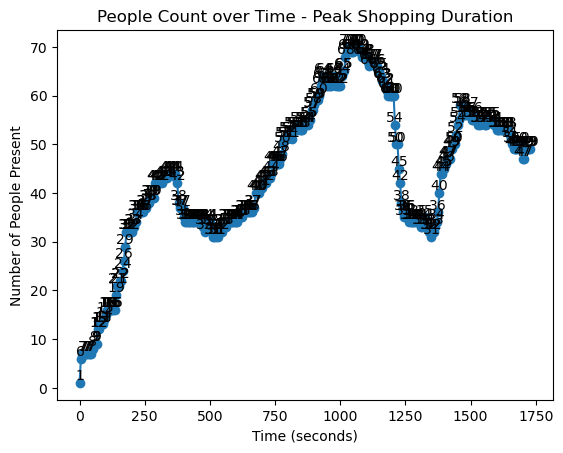

In [2]:
#task - 2
import cv2
import numpy as np
from scipy.spatial import distance as dist
from collections import OrderedDict
import matplotlib.pyplot as plt

# Helper class for centroid-based tracking
class CentroidTracker:
    def __init__(self, max_disappeared=50):
        self.next_object_id = 0
        self.objects = OrderedDict()
        self.disappeared = OrderedDict()
        self.max_disappeared = max_disappeared

    def register(self, centroid):
        self.objects[self.next_object_id] = centroid
        self.disappeared[self.next_object_id] = 0
        self.next_object_id += 1

    def deregister(self, object_id):
        del self.objects[object_id]
        del self.disappeared[object_id]

    def update(self, input_centroids):
        if len(input_centroids) == 0:
            for object_id in list(self.disappeared.keys()):
                self.disappeared[object_id] += 1
                if self.disappeared[object_id] > self.max_disappeared:
                    self.deregister(object_id)
            return self.objects

        if len(self.objects) == 0:
            for centroid in input_centroids:
                self.register(centroid)
        else:
            object_ids = list(self.objects.keys())
            object_centroids = list(self.objects.values())

            D = dist.cdist(np.array(object_centroids), input_centroids)
            rows = D.min(axis=1).argsort()
            cols = D.argmin(axis=1)[rows]

            used_rows, used_cols = set(), set()

            for (row, col) in zip(rows, cols):
                if row in used_rows or col in used_cols:
                    continue

                object_id = object_ids[row]
                self.objects[object_id] = input_centroids[col]
                self.disappeared[object_id] = 0

                used_rows.add(row)
                used_cols.add(col)

            unused_rows = set(range(0, D.shape[0])).difference(used_rows)
            unused_cols = set(range(0, D.shape[1])).difference(used_cols)

            for row in unused_rows:
                object_id = object_ids[row]
                self.disappeared[object_id] += 1
                if self.disappeared[object_id] > self.max_disappeared:
                    self.deregister(object_id)

            for col in unused_cols:
                self.register(input_centroids[col])

        return self.objects

video = cv2.VideoCapture("C:/Users/sivalohit/Downloads/BB_01e962ad-8ac3-43ec-81c1-870c9cd83284.mov")
bg_subtractor = cv2.createBackgroundSubtractorMOG2()
ct = CentroidTracker(max_disappeared=40)

frame_count = 0
frame_people_counts = []

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    fg_mask = bg_subtractor.apply(frame)
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    input_centroids = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 500:
            M = cv2.moments(cnt)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            input_centroids.append((cX, cY))

    objects = ct.update(input_centroids)

    for (object_id, centroid) in objects.items():
        text = f"ID {object_id}"
        cv2.putText(frame, text, (centroid[0] - 10, centroid[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.circle(frame, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)

    frame_people_counts.append(len(objects))
    frame_count += 1

    cv2.putText(frame, f"Current People Count: {len(objects)}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

    cv2.imshow("People Counting", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

time_intervals = np.arange(0, len(frame_people_counts) * 5, 5)  # Adjust based on frame rate
plt.plot(time_intervals, frame_people_counts, marker='o')
plt.xlabel("Time (seconds)")
plt.ylabel("Number of People Present")
plt.title("People Count over Time - Peak Shopping Duration")

for i, count in enumerate(frame_people_counts):
    plt.text(time_intervals[i], count, str(count), ha='center', va='bottom')

plt.show()


In [3]:
#task - 3
import cv2

ref_image = cv2.imread("C:/Users/sivalohit/Downloads/Screenshot 2024-11-10 173318.png", cv2.IMREAD_GRAYSCALE)
video = cv2.VideoCapture("C:/Users/sivalohit/Downloads/Input_lab_6.mov")
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        face = gray_frame[y:y+h, x:x+w]

        
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(frame, "Match Found", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    cv2.imshow("Face Recognition", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()


In [4]:
#Task - 4
import cv2

video = cv2.VideoCapture("C:/Users/sivalohit/Downloads/uhd_30fps.mp4")
bg_subtractor = cv2.createBackgroundSubtractorMOG2()
entrance_counter_in = 0
entrance_counter_out = 0

person_ids = set()

frame_counter = 0
fps = video.get(cv2.CAP_PROP_FPS)

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    fg_mask = bg_subtractor.apply(frame)
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        if cv2.contourArea(cnt) > 500:
            x, y, w, h = cv2.boundingRect(cnt)
            cx, cy = x + w // 2, y + h // 2 

            if cx not in person_ids:

                entrance_counter_in += 1
                person_ids.add(cx)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            else:

                entrance_counter_out += 1
                person_ids.remove(cx)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)

    cv2.putText(frame, f"Entered: {entrance_counter_in}, Exited: {entrance_counter_out}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    cv2.imshow("Counting", frame)
    frame_counter += 1
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

print(f"Total people entered the store: {entrance_counter_in}")
print(f"Total people exited the store: {entrance_counter_out}")


Total people entered the store: 2843
Total people exited the store: 2225


In [5]:
#Task - 5
import cv2
import time

video = cv2.VideoCapture("C:/Users/sivalohit/Downloads/uhd_30fps.mp4")

frame_count = 0
fps = video.get(cv2.CAP_PROP_FPS)
unique_person_count = 0
people_in_frame = {}

person_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_fullbody.xml')

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    persons = person_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    current_frame_ids = set()
    for (x, y, w, h) in persons:
   
        person_id = f"{x}-{y}-{w}-{h}"

        if person_id not in people_in_frame:
         
            people_in_frame[person_id] = {'entry_time': frame_count / fps, 'exit_time': None}
            unique_person_count += 1
        else:
          
            people_in_frame[person_id]['exit_time'] = frame_count / fps

        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, f"Person {unique_person_count}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        current_frame_ids.add(person_id)

    for person_id in list(people_in_frame.keys()):
        if person_id not in current_frame_ids and people_in_frame[person_id]['exit_time'] is None:
           
            people_in_frame[person_id]['exit_time'] = frame_count / fps

    cv2.imshow('Video', frame)

    frame_count += 1

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

print("Total unique persons detected in video:", unique_person_count)
for person_id, times in people_in_frame.items():
    entry_time = times['entry_time']
    exit_time = times['exit_time'] if times['exit_time'] is not None else frame_count / fps  # If person was in the last frame
    dwell_time = exit_time - entry_time
    print(f"Person ID: {person_id} | Entry Time: {entry_time:.2f}s | Exit Time: {exit_time:.2f}s | Dwell Time: {dwell_time:.2f}s")


Total unique persons detected in video: 95
Person ID: 2411-237-44-89 | Entry Time: 0.03s | Exit Time: 12.18s | Dwell Time: 12.15s
Person ID: 2411-236-45-90 | Entry Time: 0.97s | Exit Time: 1.10s | Dwell Time: 0.13s
Person ID: 2411-237-43-87 | Entry Time: 1.13s | Exit Time: 1.17s | Dwell Time: 0.03s
Person ID: 2412-236-44-89 | Entry Time: 1.37s | Exit Time: 1.40s | Dwell Time: 0.03s
Person ID: 1105-782-36-72 | Entry Time: 1.47s | Exit Time: 1.50s | Dwell Time: 0.03s
Person ID: 2410-237-44-89 | Entry Time: 1.47s | Exit Time: 1.50s | Dwell Time: 0.03s
Person ID: 1227-467-60-121 | Entry Time: 3.44s | Exit Time: 3.47s | Dwell Time: 0.03s
Person ID: 1226-459-64-128 | Entry Time: 3.50s | Exit Time: 3.54s | Dwell Time: 0.03s
Person ID: 1228-463-59-119 | Entry Time: 3.67s | Exit Time: 3.70s | Dwell Time: 0.03s
Person ID: 1226-460-63-127 | Entry Time: 3.70s | Exit Time: 3.74s | Dwell Time: 0.03s
Person ID: 1227-464-60-121 | Entry Time: 3.74s | Exit Time: 3.77s | Dwell Time: 0.03s
Person ID: 1226

In [6]:
#Task - 6
import cv2

def count_cars(video_path):
    cap = cv2.VideoCapture(video_path)

    # Create a background subtractor
    bg_subtractor = cv2.createBackgroundSubtractorMOG2()

    car_count = 0

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        # Apply background subtraction
        fg_mask = bg_subtractor.apply(frame)

        # Find contours in the foreground mask
        contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area > 300:  # Adjust threshold as needed
                car_count += 1

        cv2.imshow('Frame', frame)
        cv2.imshow('FG Mask', fg_mask)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    return car_count

# Replace 'your_video_path.mp4' with your actual video path
video_path = "C:/Users/sivalohit/Downloads/5971_Underpass_Traffic_1920x1080.mp4"
total_cars = count_cars(video_path)
print("Total cars detected:", total_cars)

Total cars detected: 16469
